In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import wandb
import pandas as pd

In [2]:
from sine_data_generator import SineDataGenerator
from models.decoder import Decoder
from models.utils import ReluNet, make_leave_one_out
from models.encoder import DeterministicIOPairSetEncoder
from models.lpn import DeterministicLPN


In [3]:
def set_seed(seed=1):
    np.random.seed(seed)                      
    torch.manual_seed(seed)                   
    torch.cuda.manual_seed(seed)              
    torch.cuda.manual_seed_all(seed)          
    
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False    

set_seed(1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_latent = 2

In [5]:

# Create encoder
encoder = DeterministicIOPairSetEncoder(
    phi=ReluNet(2, 32, 32),
    rho_0=ReluNet(32, 32, 16),
    rho_1=ReluNet(16, 8, d_latent)
)

# Create decoder
decoder = Decoder(
    d_input=1, 
    d_latent=d_latent, 
    ds_hidden=[32, 32], 
    d_output=1
)

# Create the model
lpn = DeterministicLPN(
    d_input=1,
    d_output=1,
    d_latent=d_latent,
    encoder=encoder,
    decoder=decoder
).to(device)

# Create data generator for training
n_samples_per_task = 20
batch_size = 25
data_gen = SineDataGenerator(n_samples_per_task, batch_size)
print(type(data_gen))
print(data_gen.generate()[0].shape)

<class 'sine_data_generator.SineDataGenerator'>
torch.Size([25, 20, 1])


In [6]:
# Training function
def train_deterministic_lpn(lpn, data_gen, device):
    wandb.init(project="deterministic_lpn4sine_cf_maml")
        
    n_metaiter = 30_001 
    n_samples_per_task = 20
    batch_size = 25
    numstep = 2 # changed this from 1
    d_latent = lpn.d_latent
    
    print("Total parameters:", sum(p.numel() for p in lpn.parameters()))
    
    optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)
    
    losses = []
    
    for i in range(n_metaiter):
        lpn.train()
        optimizer.zero_grad()
        
        xs, ys, amp, phase = data_gen.generate()
        io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)
        
        _, loss = lpn(io_pairs, K=numstep, debug=(i==0))
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
    
    # Save the model
    torch.save(lpn.state_dict(), f'deterministic_lpn_H{d_latent}_GA{numstep}.pth')
    wandb.finish()
    
    return losses

# Evaluation function
def evaluate_deterministic_lpn(lpn, device):
    n_test_points = 2000
    test_batch_size = 1
    n_test_samples_per_task = 20
    n_support_samples_per_task = 10
    n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task
    
    test_numstep = 10 #100
    data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)
    
    
    metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)
    
    for i_test_task in range(n_test_points):
        test_xs, test_ys, amp, phase = data_gen.generate()
        support_xs = test_xs[:, :n_support_samples_per_task, :]
        support_ys = test_ys[:, :n_support_samples_per_task, :]
        query_xs = test_xs[:, n_support_samples_per_task:, :]
        query_ys = test_ys[:, n_support_samples_per_task:, :]
        
        support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)
        aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)
        
        # Note: Different key names from the probabilistic version
        z_traj = aux_t["z_traj"]
        print(len(z_traj))
        print(test_numstep + 1)
        assert len(z_traj) == test_numstep + 1
        for i_step, z in enumerate(z_traj):
            z = z.mean(dim=1).squeeze(0)  # (d_latent,)
            
            # Evaluate MSE loss of z on the query set
            query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
            mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
            metaeval_losses[i_test_task, i_step] = mse.item()
    
    # Calculate confidence intervals correctly
    n_samples = metaeval_losses.shape[0]
    metaeval_mu = metaeval_losses.mean(axis=0)
    metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)
    
    lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
    upper_err = metaeval_ci
    yerr = np.vstack([lower_err, upper_err])
    
    x = np.arange(test_numstep + 1)
    plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
    plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)
    
    plt.xlabel('Gradient Steps')
    plt.ylabel('Loss')
    plt.title('Meta-evaluation Loss vs Gradient Steps (Deterministic LPN)')
    plt.show()
    
    return metaeval_losses, metaeval_mu, metaeval_ci

# Visualization function
def visualize_deterministic_lpn(lpn, device):
    # Generate test data
    test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()
    
    amp = amp.item()
    phase = phase.item()
    
    io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)
    aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)
    
    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    
    # Note: Different key names compared to the probabilistic version
    z = aux_t["z"].detach() if "z" in aux_t else None
    z_prime = aux_t["z_prime"].detach()
    
    # Plot visualization
    x = np.linspace(-5, 5, 200)
    
    for i in range(10):
        # Plot ground-truth
        y = amp * np.sin(x - phase)
        plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)
        
        # Plot samples
        plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)
        
        # Plot target x,y (sample i of batch 0), and its prediction
        x_i = test_xs[0, i].item()
        y_i = test_ys[0, i].item()
        yhat_i = y_pred[0, i].item()
        plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
        plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)
        
        # Plot the predicted latent program
        x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (200, 1)
        
        # Plot using initial z if available
        if z is not None:
            z_i = z[0, i]
            y_pred_z_i = lpn.decode(z_i, x_prep).detach().cpu().numpy()
            plt.plot(x, y_pred_z_i, label="predictions (by initial z)",
                     color='orange', linestyle='dashed', alpha=1, zorder=45)
        
        # Plot using optimized z_prime
        z_pr_i = z_prime[0, i]
        y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
        plt.plot(x, y_pred_z_pr_i, label="predictions (by optimized z')",
                 color='k', linestyle='dashed', alpha=1, zorder=50)
        
        plt.xlabel("Inputs x")
        plt.ylabel("Outputs y")
        plt.title(f"Deterministic LPN Predictions (Sample {i+1})")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [7]:
losses = train_deterministic_lpn(lpn, data_gen, device)


wandb: Currently logged in as: stephen-marcou (stephen-marcou-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total parameters: 4107
torch.sum(mse).item()=35971.4375
torch.sum(mse).item()=35971.17578125
Step 0, Loss: 3.7864
Step 1000, Loss: 1.2599
Step 2000, Loss: 0.5076
Step 3000, Loss: 0.2652
Step 4000, Loss: 0.2562
Step 5000, Loss: 0.1228
Step 6000, Loss: 0.1533
Step 7000, Loss: 0.0774
Step 8000, Loss: 0.0537
Step 9000, Loss: 0.0410
Step 10000, Loss: 0.0549
Step 11000, Loss: 0.0239
Step 12000, Loss: 0.1063
Step 13000, Loss: 0.1435
Step 14000, Loss: 0.0306
Step 15000, Loss: 0.0545
Step 16000, Loss: 0.0477
Step 17000, Loss: 0.2823
Step 18000, Loss: 0.0815
Step 19000, Loss: 0.1212
Step 20000, Loss: 0.1069
Step 21000, Loss: 0.0416
Step 22000, Loss: 0.0386
Step 23000, Loss: 0.0472
Step 24000, Loss: 0.0566
Step 25000, Loss: 0.1368
Step 26000, Loss: 0.1390
Step 27000, Loss: 0.0663
Step 28000, Loss: 0.0257
Step 29000, Loss: 0.0721
Step 30000, Loss: 0.0417


loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.04174


torch.sum(mse).item()=5.13430118560791
torch.sum(mse).item()=2.1521310806274414
torch.sum(mse).item()=1.1514286994934082
torch.sum(mse).item()=0.7639236450195312
torch.sum(mse).item()=0.6159762740135193
torch.sum(mse).item()=0.5555805563926697
torch.sum(mse).item()=0.5267427563667297
torch.sum(mse).item()=0.5163654685020447
torch.sum(mse).item()=0.512566089630127
torch.sum(mse).item()=0.5111600756645203
11
11
torch.sum(mse).item()=65.37866973876953
torch.sum(mse).item()=32.05958938598633
torch.sum(mse).item()=18.587671279907227
torch.sum(mse).item()=10.797028541564941
torch.sum(mse).item()=6.161159515380859
torch.sum(mse).item()=3.6281847953796387
torch.sum(mse).item()=2.3093934059143066
torch.sum(mse).item()=1.6333906650543213
torch.sum(mse).item()=1.2763423919677734
torch.sum(mse).item()=1.0819571018218994
11
11
torch.sum(mse).item()=17.38663673400879
torch.sum(mse).item()=3.3708887100219727
torch.sum(mse).item()=1.064182162284851
torch.sum(mse).item()=0.6794365048408508
torch.sum(ms

/var/folders/wb/9whmmh7s5bvf174ppr2jwprr0000gn/T/ipykernel_29371/304116979.py:75: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=0.9123548269271851
torch.sum(mse).item()=0.8878428339958191
torch.sum(mse).item()=0.8786849975585938
torch.sum(mse).item()=0.8752216100692749
11
11
torch.sum(mse).item()=5.943171501159668
torch.sum(mse).item()=2.9429895877838135
torch.sum(mse).item()=2.8733696937561035
torch.sum(mse).item()=2.8466687202453613
torch.sum(mse).item()=2.8334929943084717
torch.sum(mse).item()=2.827085494995117
torch.sum(mse).item()=2.8239285945892334
torch.sum(mse).item()=2.822345018386841
torch.sum(mse).item()=2.8215548992156982
torch.sum(mse).item()=2.821155548095703
11
11
torch.sum(mse).item()=30.51316261291504
torch.sum(mse).item()=19.251575469970703
torch.sum(mse).item()=13.054547309875488
torch.sum(mse).item()=9.118704795837402
torch.sum(mse).item()=6.606466770172119
torch.sum(mse).item()=4.958378314971924
torch.sum(mse).item()=3.858353614807129
torch.sum(mse).item()=3.104905843734741
torch.sum(mse).item()=2.6299633979797363
torch.sum(mse).item()=2.3840949535369873
11
11
torch.su

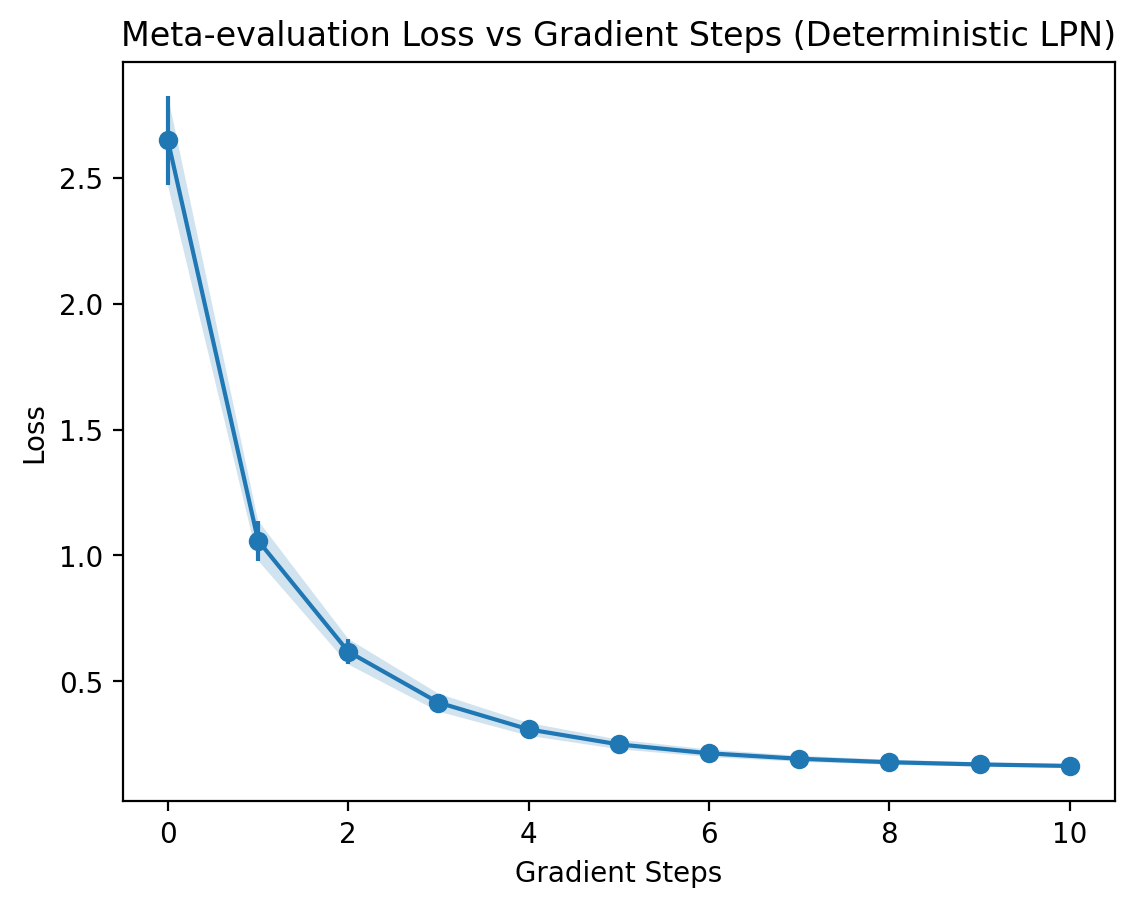

In [8]:
metaeval_losses, metaeval_mu, metaeval_ci = evaluate_deterministic_lpn(lpn, device)




In [9]:
eval_df = pd.DataFrame({"mu": metaeval_mu, "ci": metaeval_ci})

eval_df.to_csv("..//eval_data/LPN_eval_tuned2.csv")

torch.sum(mse).item()=13.999279975891113
torch.sum(mse).item()=3.959136486053467
torch.sum(mse).item()=1.5688865184783936
torch.sum(mse).item()=0.9607482552528381
torch.sum(mse).item()=0.7964832782745361
torch.sum(mse).item()=0.7486923336982727
torch.sum(mse).item()=0.7344505190849304
torch.sum(mse).item()=0.730124294757843
torch.sum(mse).item()=0.7287879586219788
torch.sum(mse).item()=0.7283684611320496
torch.sum(mse).item()=0.7282353043556213
torch.sum(mse).item()=0.7281950116157532
torch.sum(mse).item()=0.7281818389892578
torch.sum(mse).item()=0.7281771302223206
torch.sum(mse).item()=0.7281754016876221
torch.sum(mse).item()=0.7281754016876221
torch.sum(mse).item()=0.7281747460365295
torch.sum(mse).item()=0.7281749248504639
torch.sum(mse).item()=0.7281744480133057
torch.sum(mse).item()=0.7281747460365295
torch.sum(mse).item()=0.72817462682724
torch.sum(mse).item()=0.7281752228736877
torch.sum(mse).item()=0.7281742095947266
torch.sum(mse).item()=0.7281743288040161
torch.sum(mse).item(

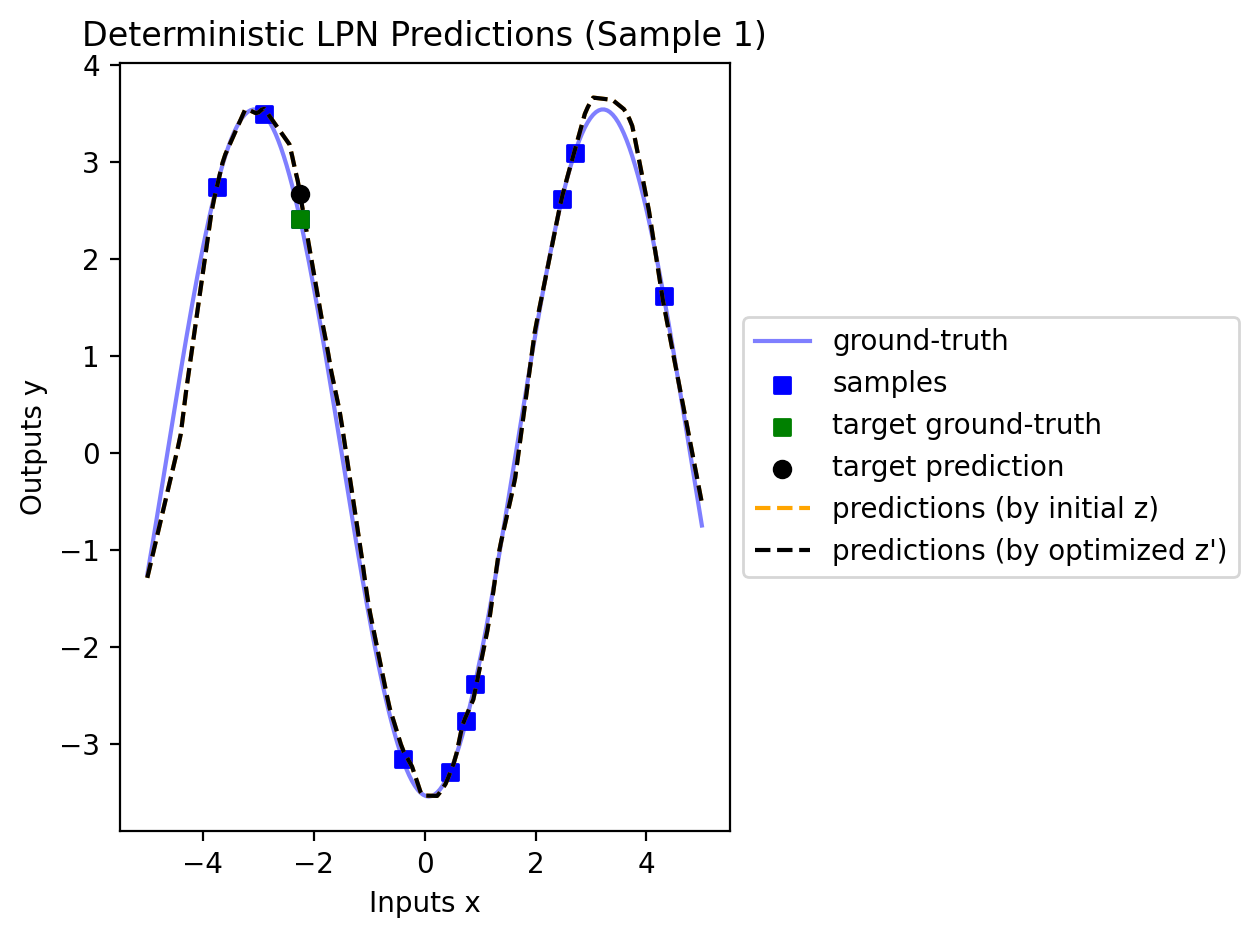

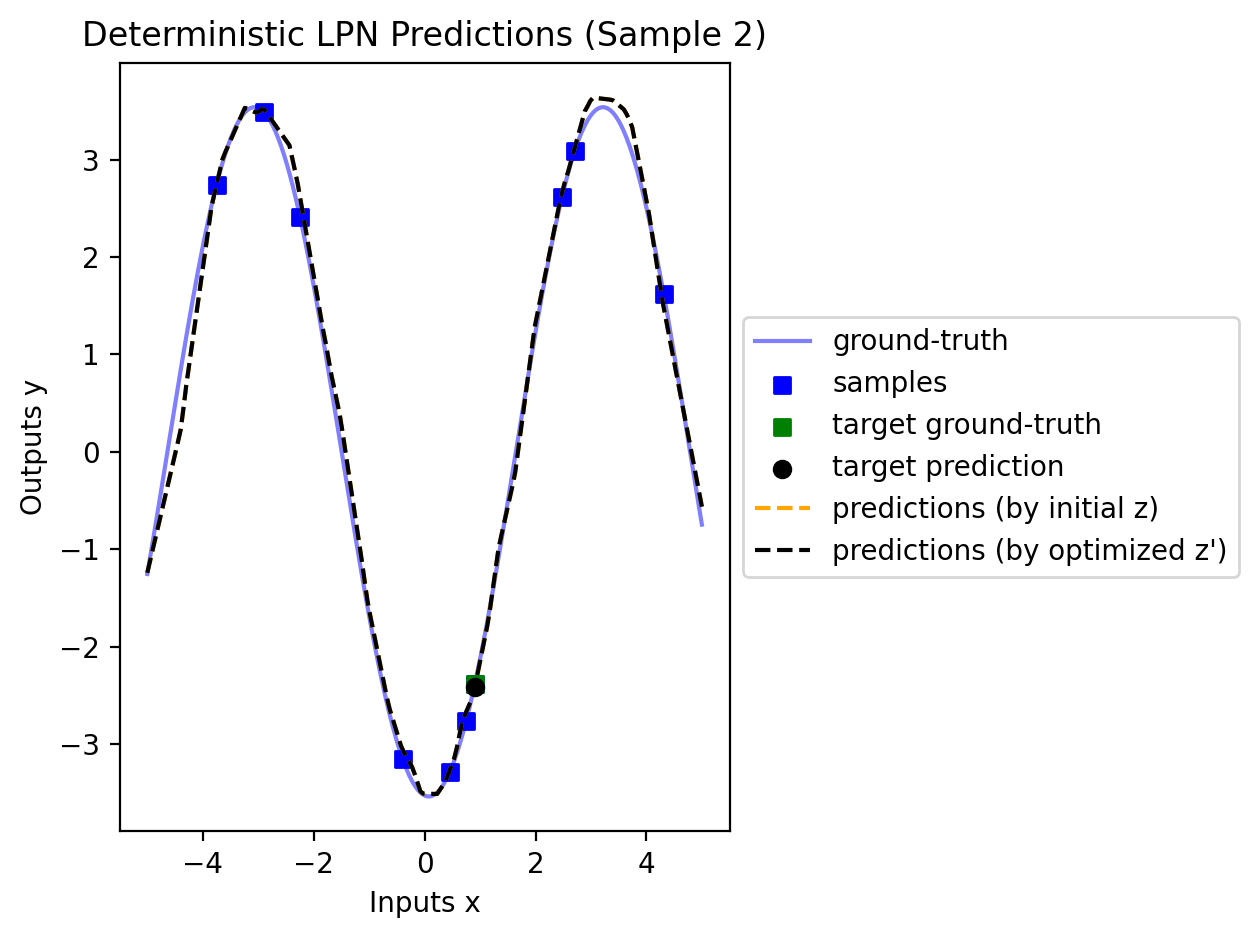

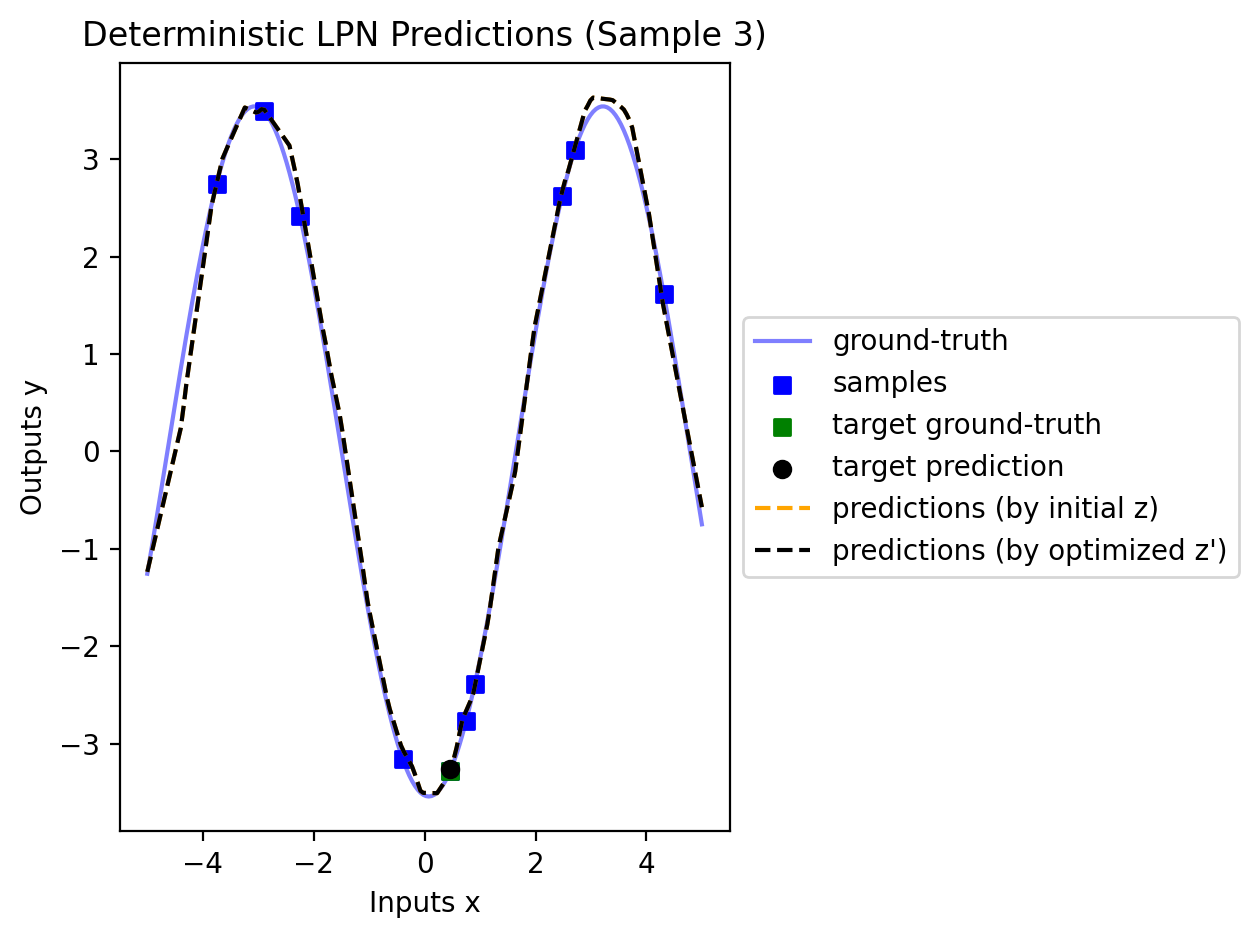

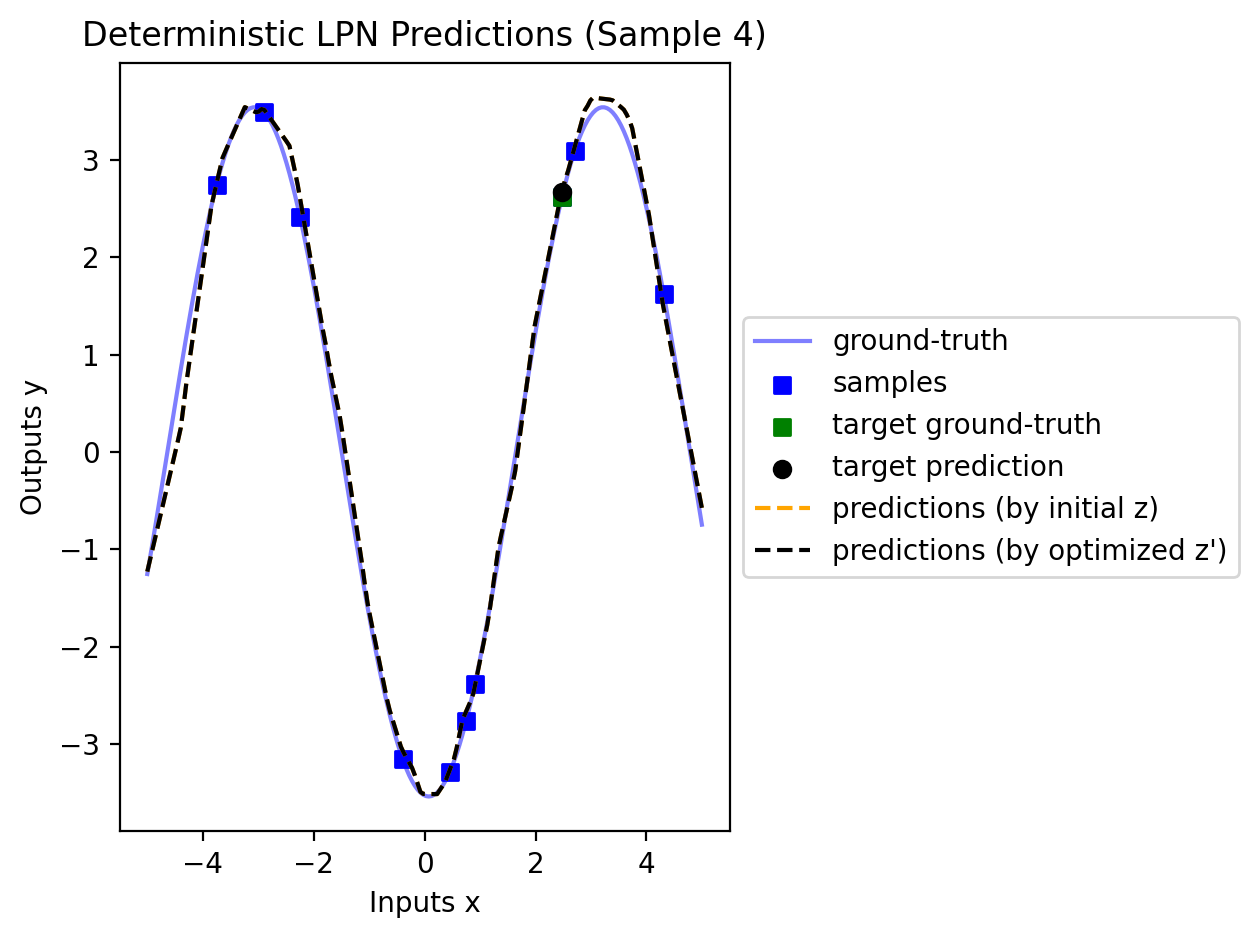

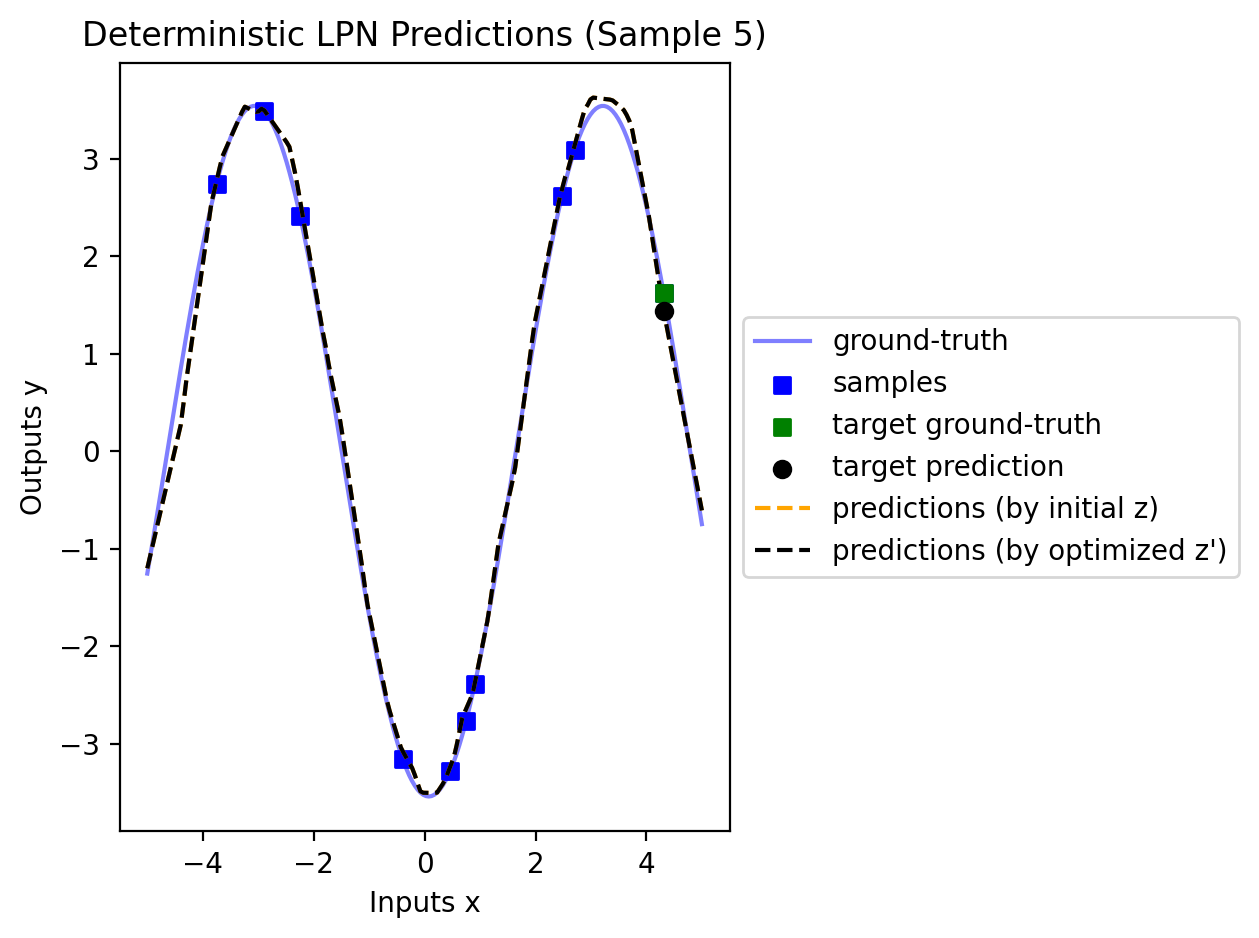

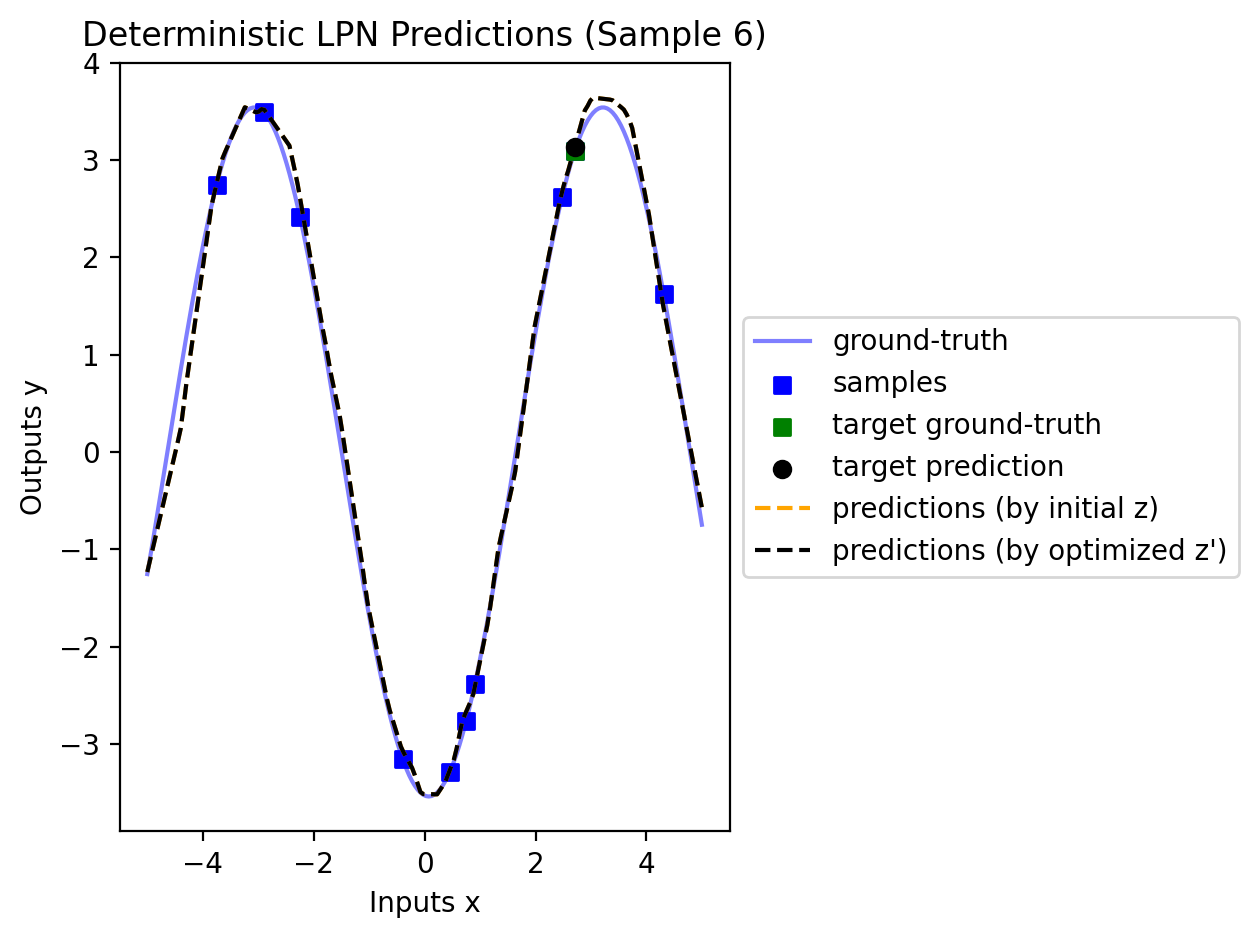

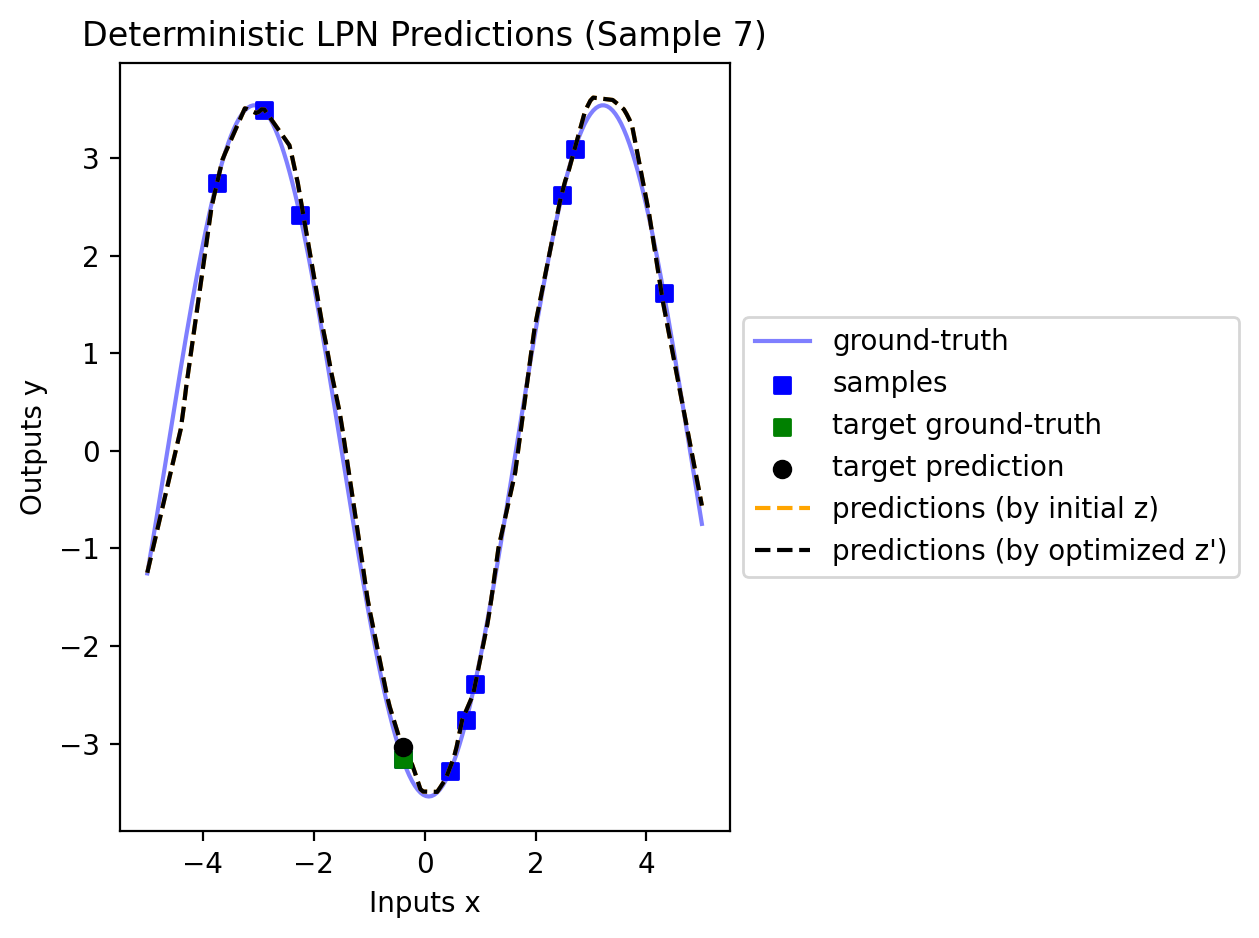

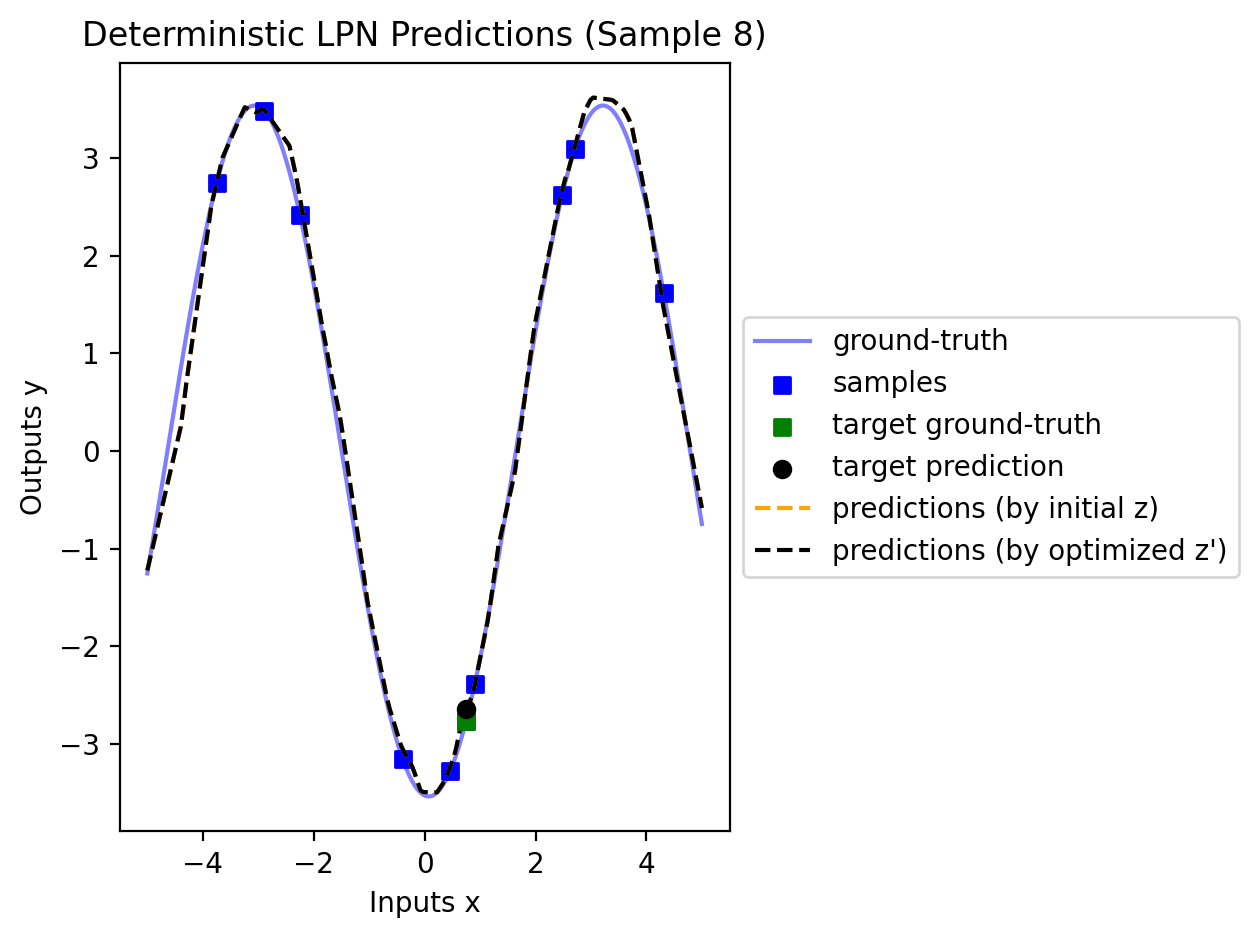

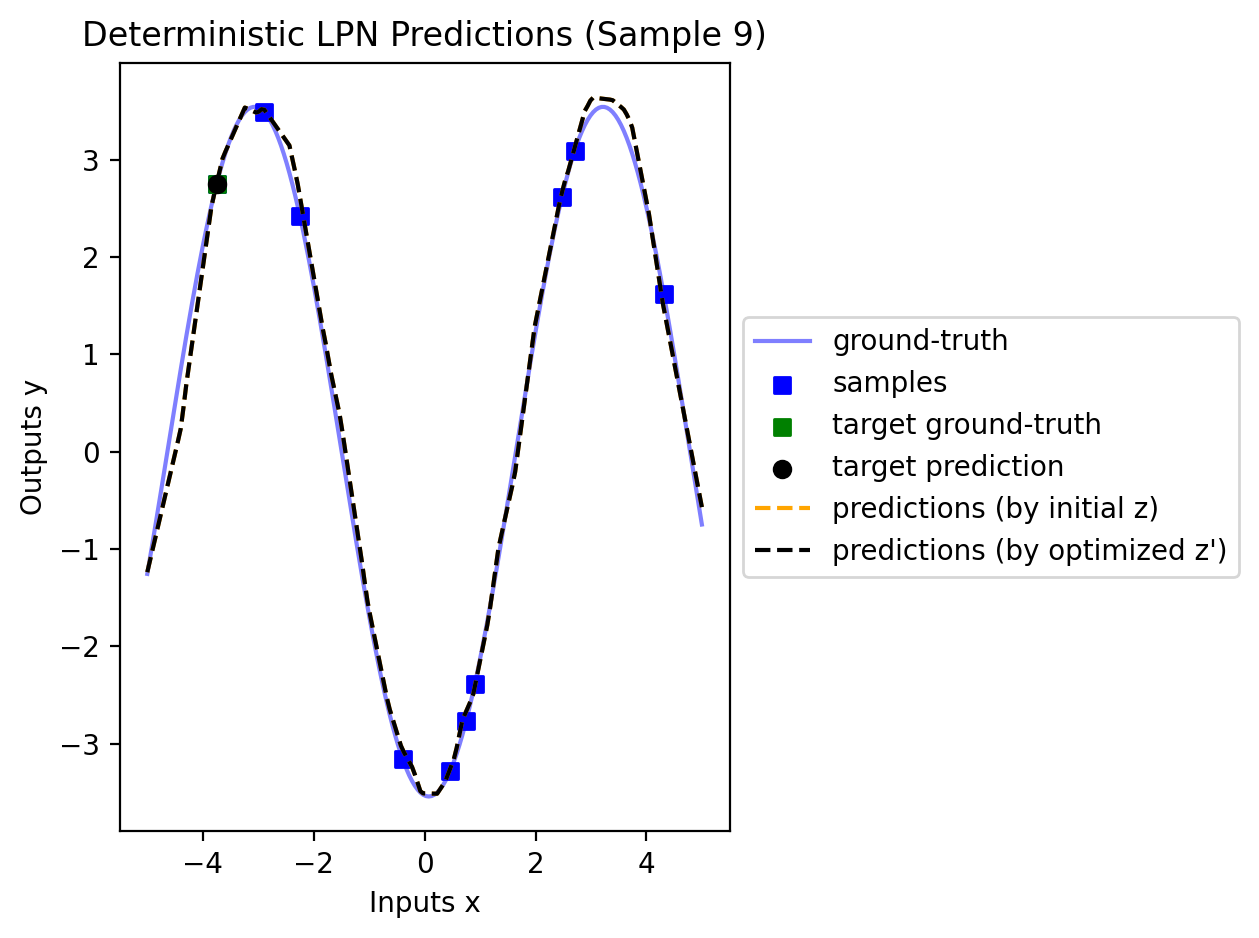

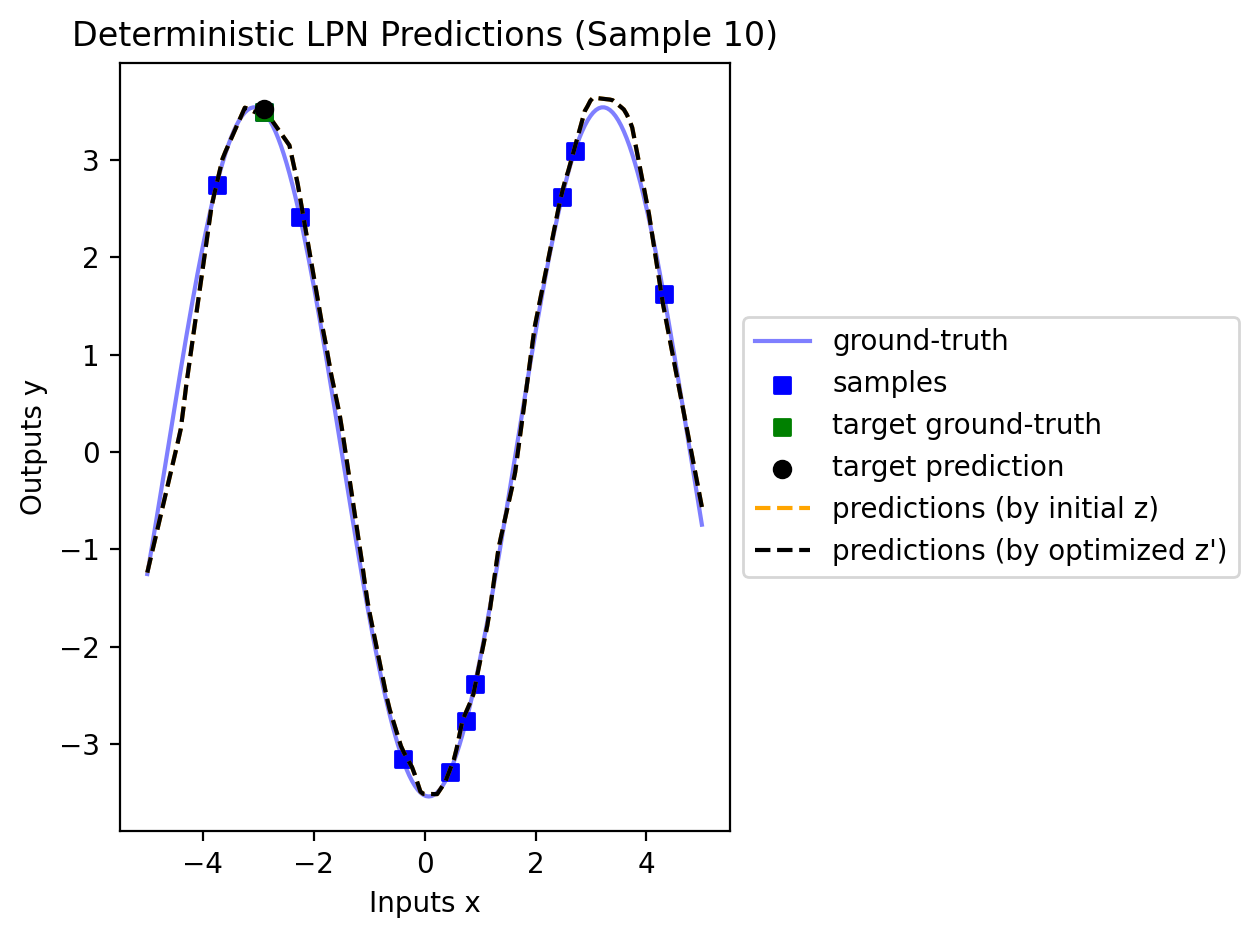

In [10]:
visualize_deterministic_lpn(lpn, device)